In [1]:
from cvm.utils import UnitConvert as uc
from matplotlib import pyplot as plt

from pprint import pprint
from collections import OrderedDict

from cvm.A1 import Tetrahedron, TetraOctahedron
from cvm.sample import Sample
from cvm.vibration import ClusterVibration

from cvm.utils import parse_formula, mixed_atomic_weight, parse_input_set, UnitConvert, cvm_context
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def percent(x, pos=0):
    return u'{:3.1f}'.format(100 * x)


def process(meta, *results, experiment=None):    

    def percent(x, pos=0):
        return u'{:3.1f}'.format(100 * x)
    
    fig, ax = plt.subplots(figsize=(8, 4.5), dpi=150)  # 800 * 500
    plt.subplots_adjust(top=0.97, bottom=0.14, left=0.12, right=0.97)

    # draw experiment
    if experiment is not None:
        y_exp = experiment['temperature']
        x_exp = experiment['concentration']
        # ax.annotate('1200$K$', (0.005, 410), fontsize=13)
        ax.plot(
            x_exp, y_exp, 'x--', mew=3, mfc='w', ms=6, lw=1.5, label='Experiment')

    # draw results
    line_type = ['o-', 'o--', 'o:']
    for i, res in enumerate(results):
        # plt.xlim(xmin=0.5, xmax=12.5)
        # plt.axhline(y=0, color='k', ls='-', lw=1.0)
        # label[i] = 'int= ' + '{:07.4}'.format(Results[i]['1st_int'])
        ax.plot(
            res['c'],
            res['temp'],
            # 'o-',
            line_type[i],
            color='darkorange',
            ms=4,
            lw=1.5,
            label=res['label'])

    # set formater
    ax.xaxis.set_major_formatter(FuncFormatter(percent))
#     ax.set_xlim(0, 0.122)

    # for preview
    ax.grid(axis='y')
    ax.tick_params(labelsize=14.5)
    ax.set_ylabel(r'Temperature, $T$/K', size=16)
    ax.set_xlabel(
        r'Concentration of ' + meta['impurity'].capitalize() +
        r', $c$/at$\%$',
        size=16)
#     ax.annotate(
#         r'(b)CVMTO10, with thermal vibration effect', (0.003, 1830), size=15)
#     ax.annotate(r'$T_\mathrm{FD}=1600$K', (0.004, 1630), size=17)
    ax.legend(loc='lower right', markerscale=1.2, fontsize=15)
    fig_name = "_".join(
        (meta['prefix'], meta['host'], meta['impurity'])).lstrip('_')
#     plt.savefig(fig_name, dpi=600)  # 300 dpi
    plt.show()



# Reading input set

In [3]:
# tetra = Tetrahedron.from_input_set('AlMg')
tetra = Tetrahedron.from_input_set('PdRh')

with cvm_context(simple_print='True'):
    print(tetra)

Tetrahedron:
  | 
  |-meta:
  |   |-host: pd
  |   |-impurity: rh
  |   |-prefix: 
  |   |-description: pdru solubility limit calculation with tetrahedron approximation
  |   |-structure: a1
  |   |-timestamp: 2019-08-17 07:19:53
  | 
  |-800k--<skip: False>


# calcaulation

# Test model fitting

### check lattice parameters

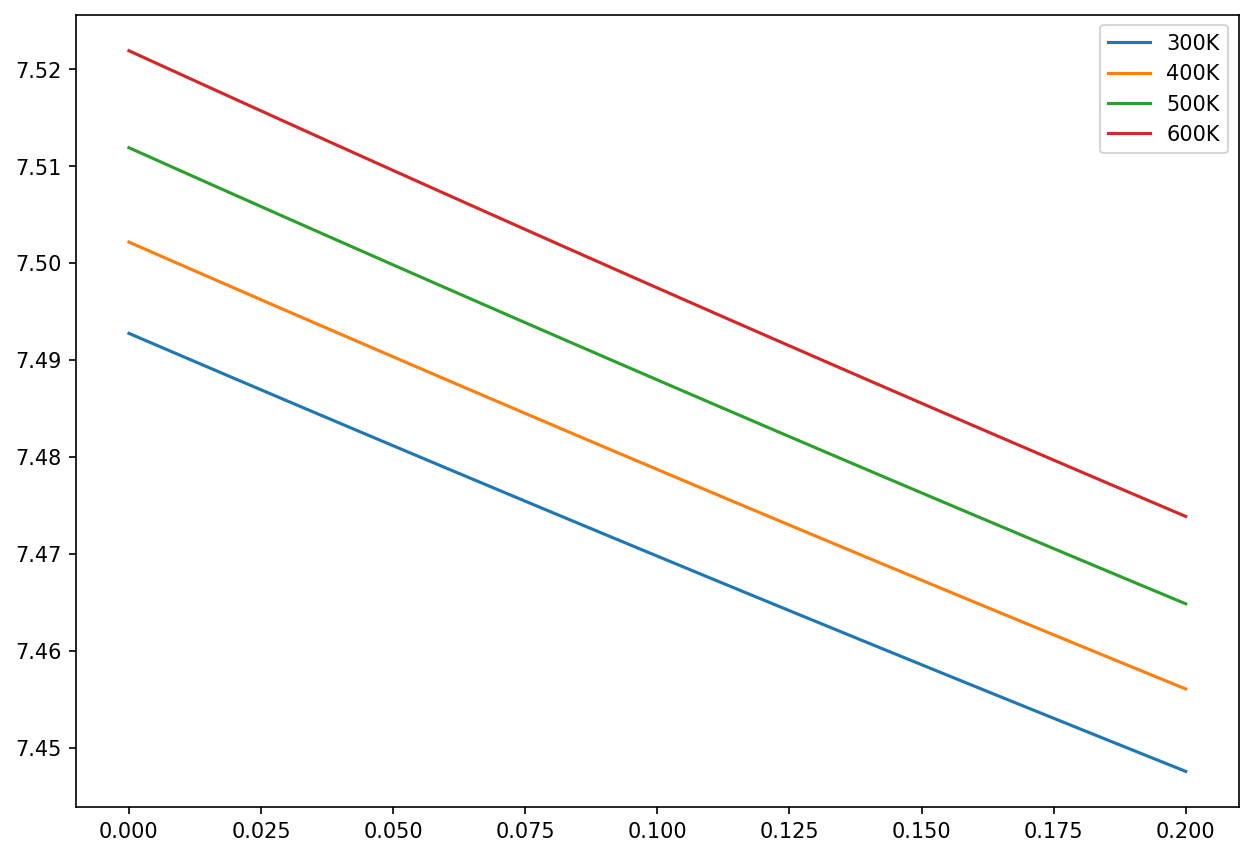

In [4]:
plt.figure(figsize=(10, 7), dpi=150)

sample = tetra.tag_800k
ls = np.linspace(0., 0.2, 50)

for T, r_0 in sample.ite(temperature=[300, 400, 500, 600]):
    plt.plot(ls, [UnitConvert.ad2lc(r_0(r)) for r in ls], label=f'{T}K')

plt.legend()

### check long-range interaction energy

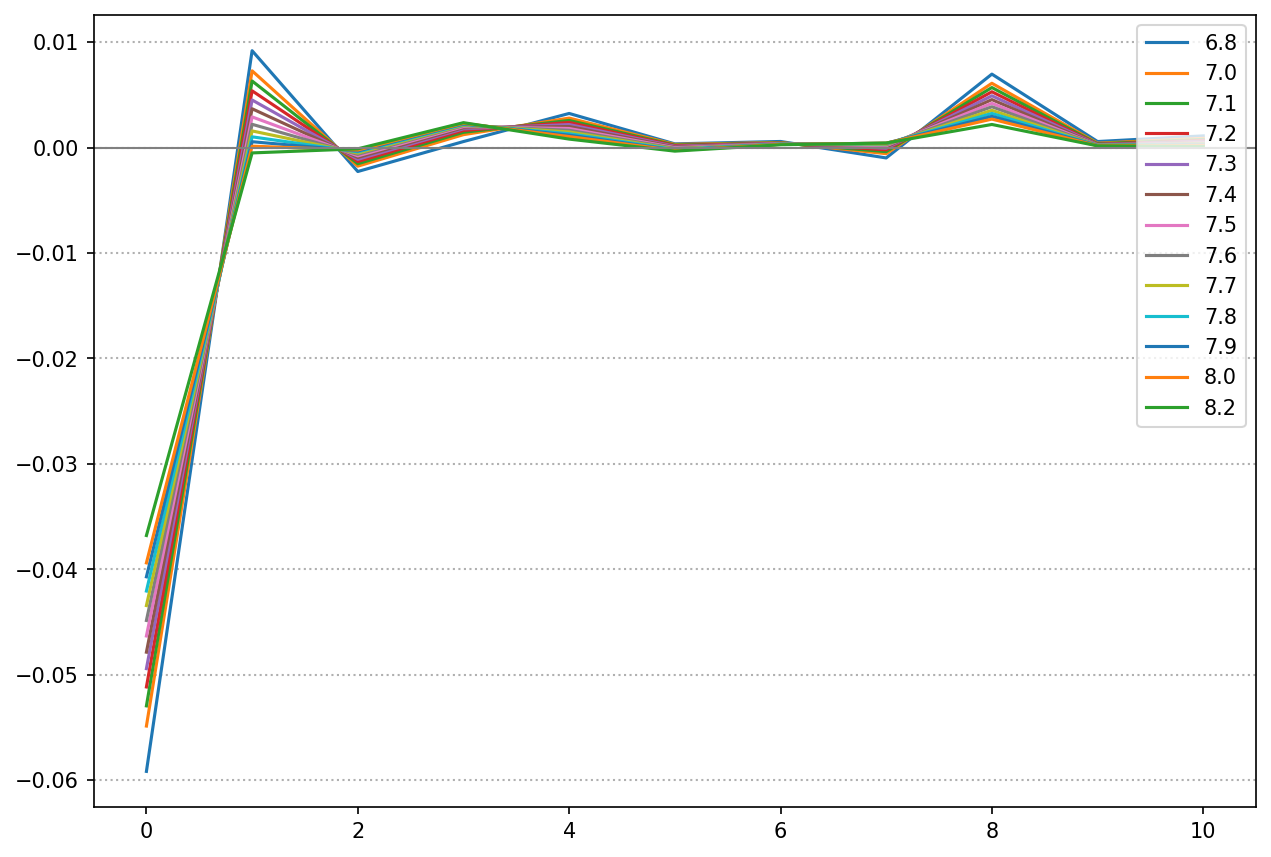

In [5]:
plt.figure(figsize=(10, 7), dpi=150)

normalizer = tetra.tag_800k.normalizer

for k, v in normalizer.interaction_energies.iteritems():
    plt.plot(v, label=str(k))
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend(loc='upper right')

### check total energy

The results are shifted by stripping the minimum energy of *Host* and *impurity*, respectively.

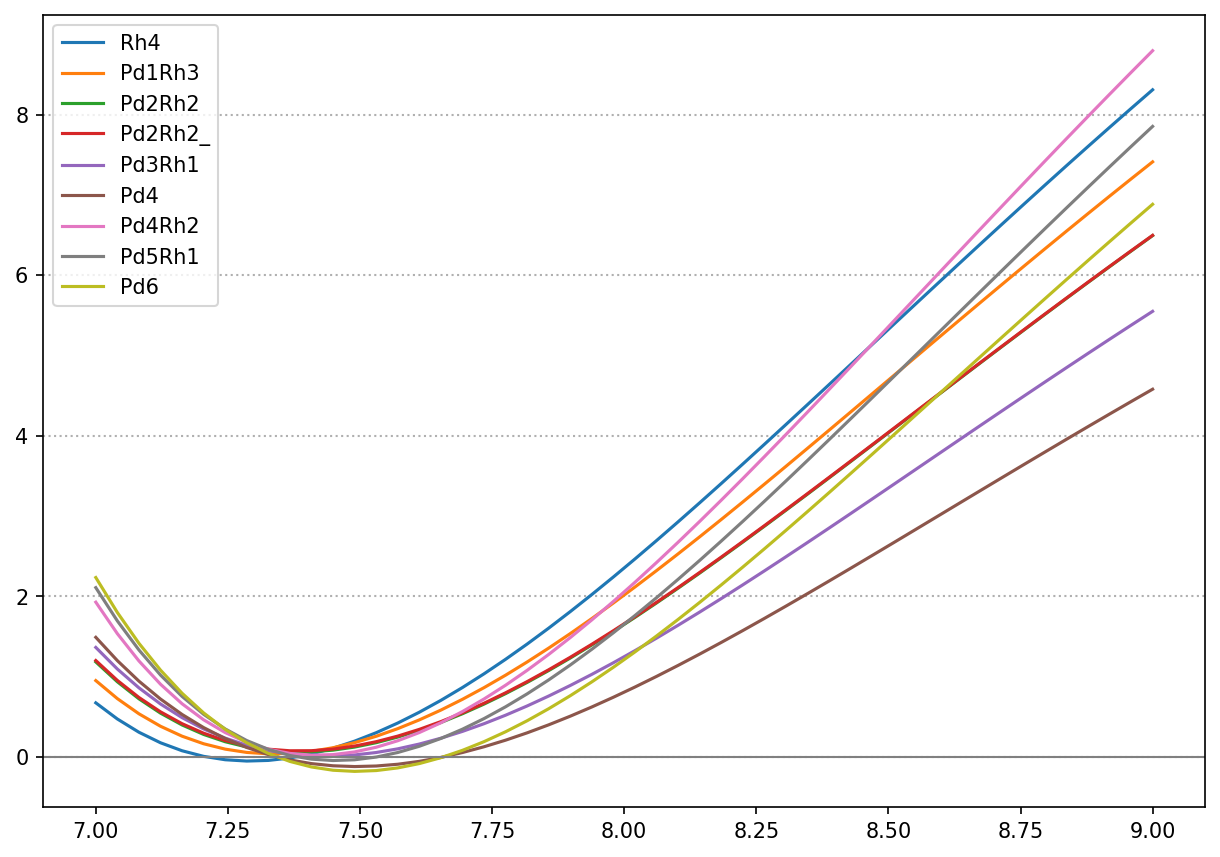

In [6]:
plt.figure(figsize=(10, 7), dpi=150)

# ls = np.linspace(6.8, 8.0, 50)
ls = np.linspace(7.0, 9.0, 50)
ls_ = UnitConvert.lc2ad(ls)

sample = tetra.tag_800k
for k, v in sample.items():
    t = [v(T=300, r=r) for r in ls_]
    plt.plot(ls, t, label=k)
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

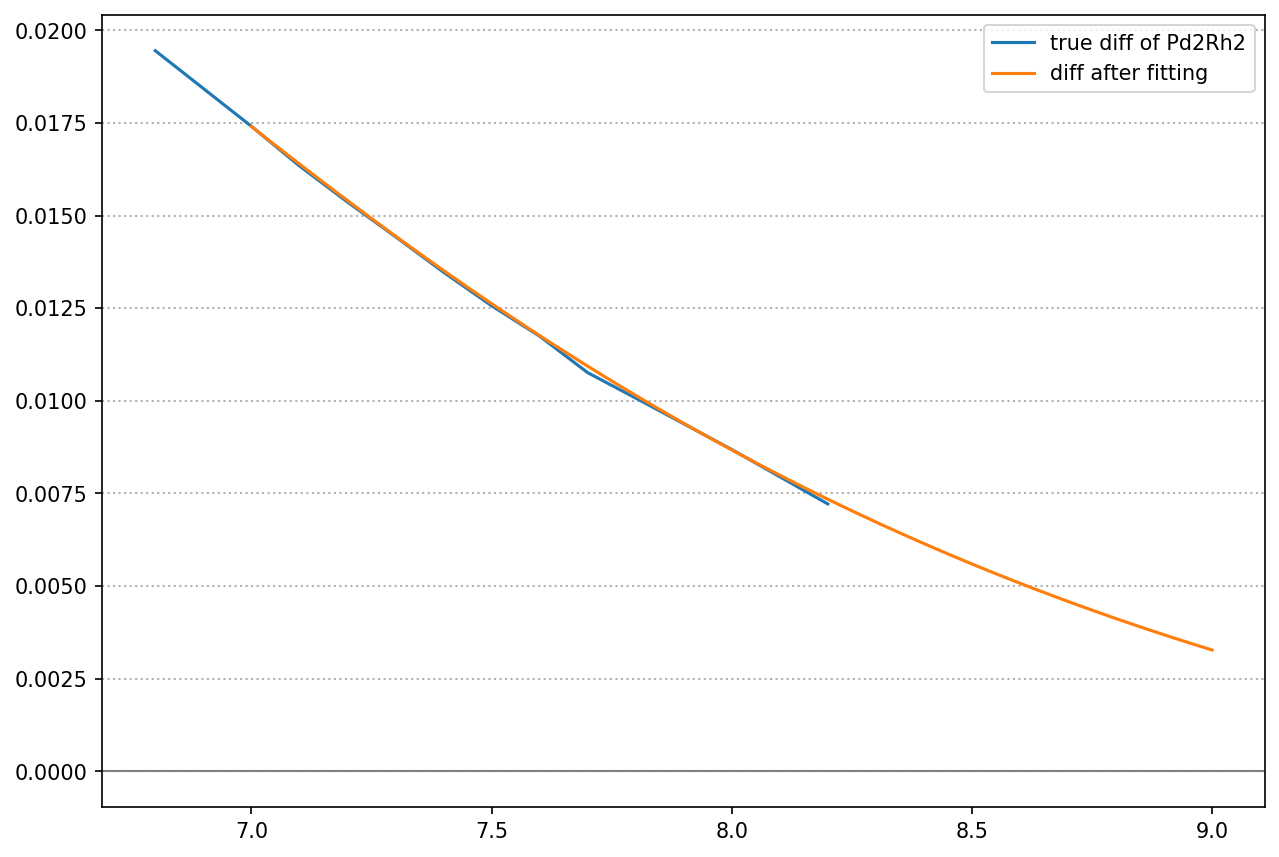

In [7]:
plt.figure(figsize=(10, 7), dpi=150)

sample = tetra.tag_800k
normalizer = sample.normalizer

for k, v in normalizer.items():
    ls = normalizer.interaction_energies.columns.values
    plt.plot(ls, v, label=f'true diff of {k}')

ls = np.linspace(7.0, 9.0, 50)
ls_ = UnitConvert.lc2ad(ls)
t = 0
for k, v in sample.items():
#     if k not in ['Al2Mg2', 'Al2Mg2_']:
    if k not in ['Pd2Rh2', 'Pd2Rh2_']:
        continue
    t = np.array([v(T=300, r=r) for r in ls_]) - t
plt.plot(ls, t, label='diff after fitting')

    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

### check interaction energy

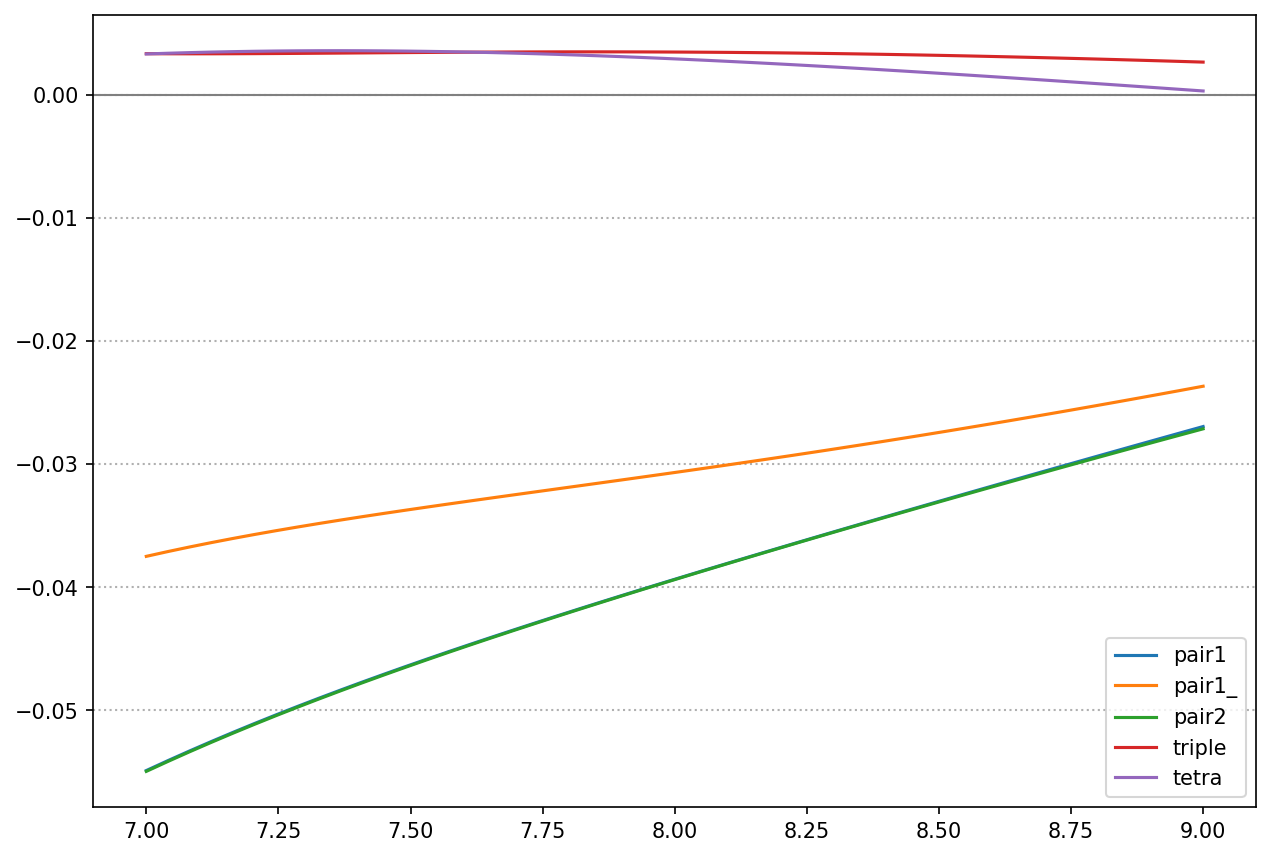

In [8]:
plt.figure(figsize=(10, 7), dpi=150)

# ls = np.linspace(6.8, 8.2, 50)
ls = np.linspace(7.0, 9.0, 50)
ls_ = UnitConvert.lc2ad(ls)

sample = tetra.tag_800k
t = pd.DataFrame([sample(T=300, r=r) for r in ls_])

for c in t:
    plt.plot(ls, t[c], label=c)
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

### check energy patch

In [9]:
def patch(_, r0):

    r0 = UnitConvert.ad2lc(r0)
    _1st = -0.075 + (-0.00365 * (r0 - 7.85) / 0.1)
    
#     return {'pair1': _1st, 'pair1_': _1st}
    return {'pair1': -0.01, 'pair1_': -0.01}

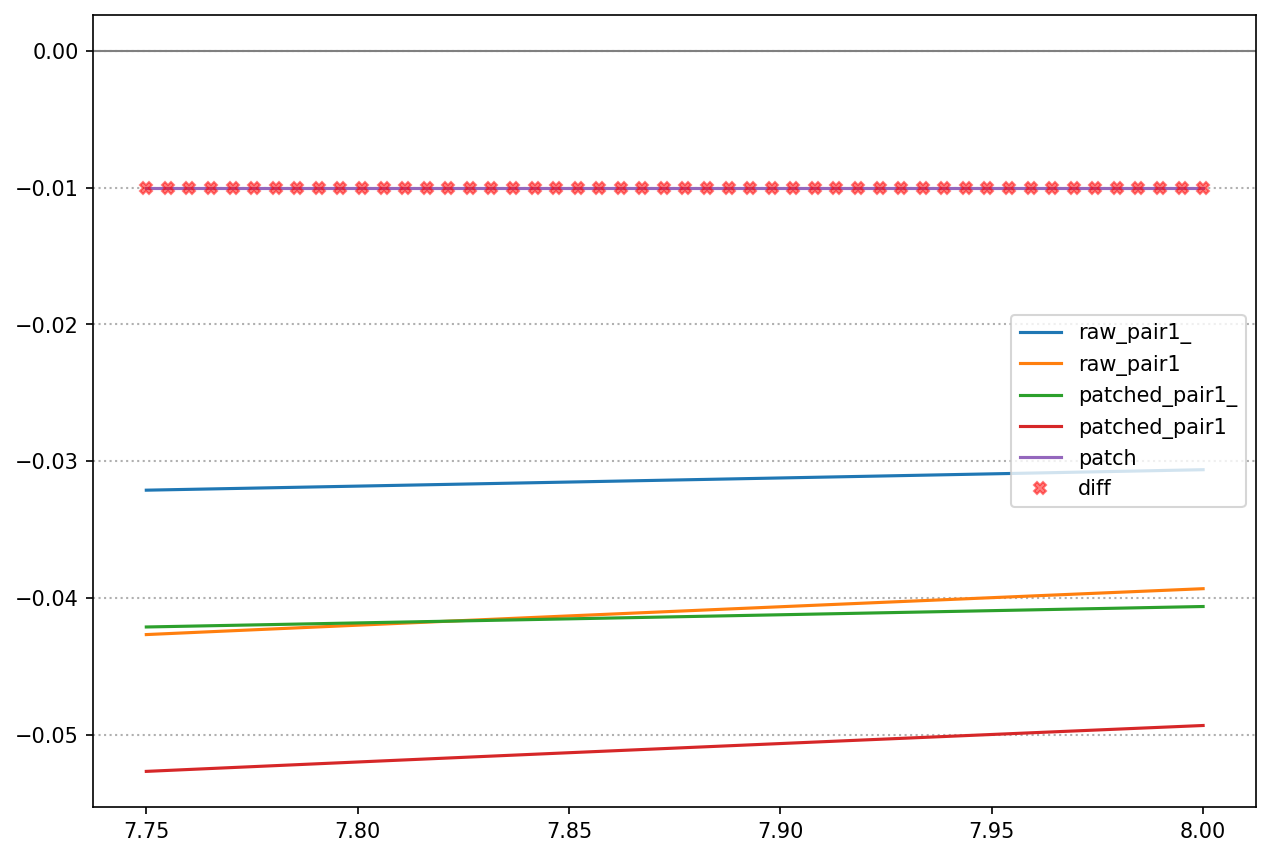

In [10]:
plt.figure(figsize=(10, 7), dpi=150)

ls = np.linspace(7.75, 8.0, 50)
ls_ = UnitConvert.lc2ad(ls)

sample = tetra.tag_800k

patch_en = [patch(_, r)['pair1'] for r in ls_]
patched_pair1 = [sample(T=400, r=r, energy_patch=patch).pair1 for r in ls_]
patched_pair1_ = [sample(T=400, r=r, energy_patch=patch).pair1_ for r in ls_]
raw_pair1 = [sample(T=400, r=r).pair1 for r in ls_]
raw_pair1_ = [sample(T=400, r=r).pair1_ for r in ls_]

t = pd.DataFrame(
    dict(raw_pair1_=raw_pair1_,
         raw_pair1=raw_pair1,
         patched_pair1_=patched_pair1_,         
         patched_pair1=patched_pair1,
         patch=patch_en,
        ))

for c in t:
    plt.plot(ls, t[c], label=c)
plt.plot(ls, t['patched_pair1'] - t['raw_pair1'], 'X', c='red', label='diff', alpha=0.5)
    
plt.axhline(y=0, color='gray', ls='-', lw=1.0)
plt.grid(axis='y', linestyle=':', linewidth=1)
# plt.ylim(-1.2, 5)
plt.legend()

# CVM calculation

In [27]:
for status in tetra(early_stopping=0.15, sample_paras=dict(energy_patch=patch, vibration=False), update_en_paras=dict(pair1='pair1_')):
    print('1st: %.5f eV' % (status.int_energy.pair1_), 'lattice param: %s' % (status.lattice_param))
    print('T=%6.3f' % status.temperature, 'Concentration=%6.4f%%' % (status.concentration * 100), 'Counts=%s' % status.num_of_ite, '\n')    

1st: -0.04406 eV lattice param: 7.4632655523887745
T=400.000 Concentration=0.1339% Counts=65 

1st: -0.04406 eV lattice param: 7.4631467722219265
T=420.690 Concentration=0.1878% Counts=70 

1st: -0.04406 eV lattice param: 7.462996725395024
T=441.379 Concentration=0.2560% Counts=72 

1st: -0.04406 eV lattice param: 7.462811104151528
T=462.069 Concentration=0.3404% Counts=75 

1st: -0.04407 eV lattice param: 7.462585486373877
T=482.759 Concentration=0.4430% Counts=77 

1st: -0.04407 eV lattice param: 7.462315279860601
T=503.448 Concentration=0.5659% Counts=80 

1st: -0.04407 eV lattice param: 7.461995693874435
T=524.138 Concentration=0.7113% Counts=82 

1st: -0.04407 eV lattice param: 7.46162164805705
T=544.828 Concentration=0.8816% Counts=85 

1st: -0.04407 eV lattice param: 7.461187704775356
T=565.517 Concentration=1.0793% Counts=88 

1st: -0.04408 eV lattice param: 7.460687943911397
T=586.207 Concentration=1.3071% Counts=92 

1st: -0.04408 eV lattice param: 7.46011583896443
T=606.897 

...Early stopping applied because the impurity concentration is greater than 0.5.Current temperature is: 917.2413793103449, concentration is: 0.1501811586775333

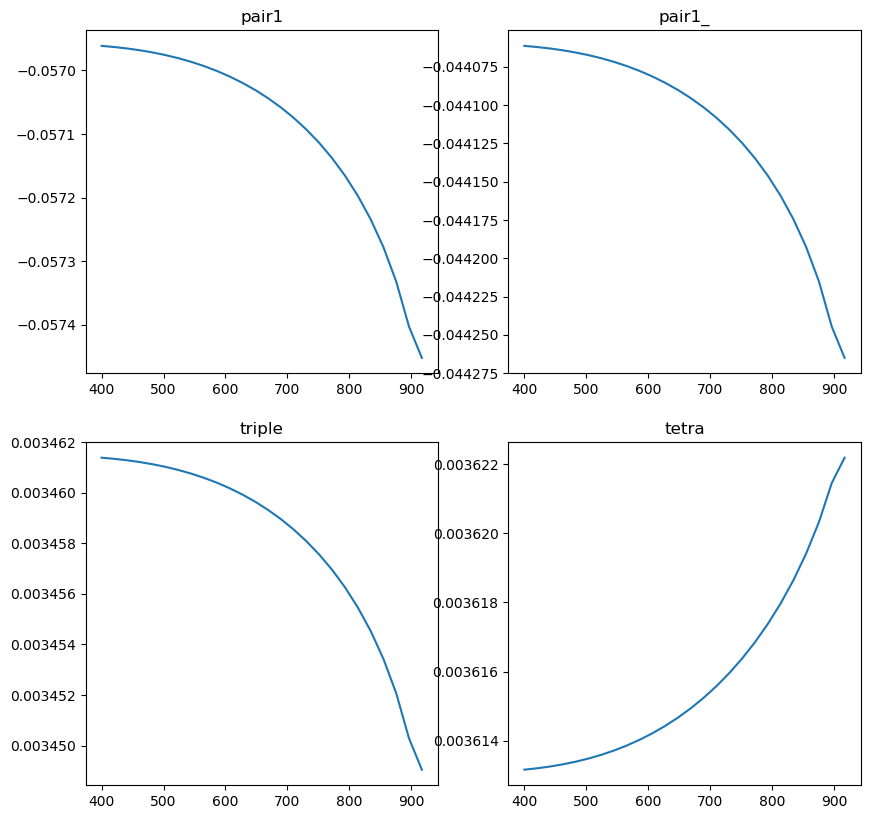

In [28]:
_, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)

ret = tetra.results.loc['800k'].groupby('temperature').last()['pair1']
ax[0, 0].set_title('pair1')
ax[0, 0].plot(ret)


ret = tetra.results.loc['800k'].groupby('temperature').last()['pair1_']
ax[0, 1].set_title('pair1_')
ax[0, 1].plot(ret)

ret = tetra.results.loc['800k'].groupby('temperature').last()['triple']
ax[1, 0].set_title('triple')
ax[1, 0].plot(ret)

ret = tetra.results.loc['800k'].groupby('temperature').last()['tetra']
ax[1, 1].set_title('tetra')
ax[1, 1].plot(ret)

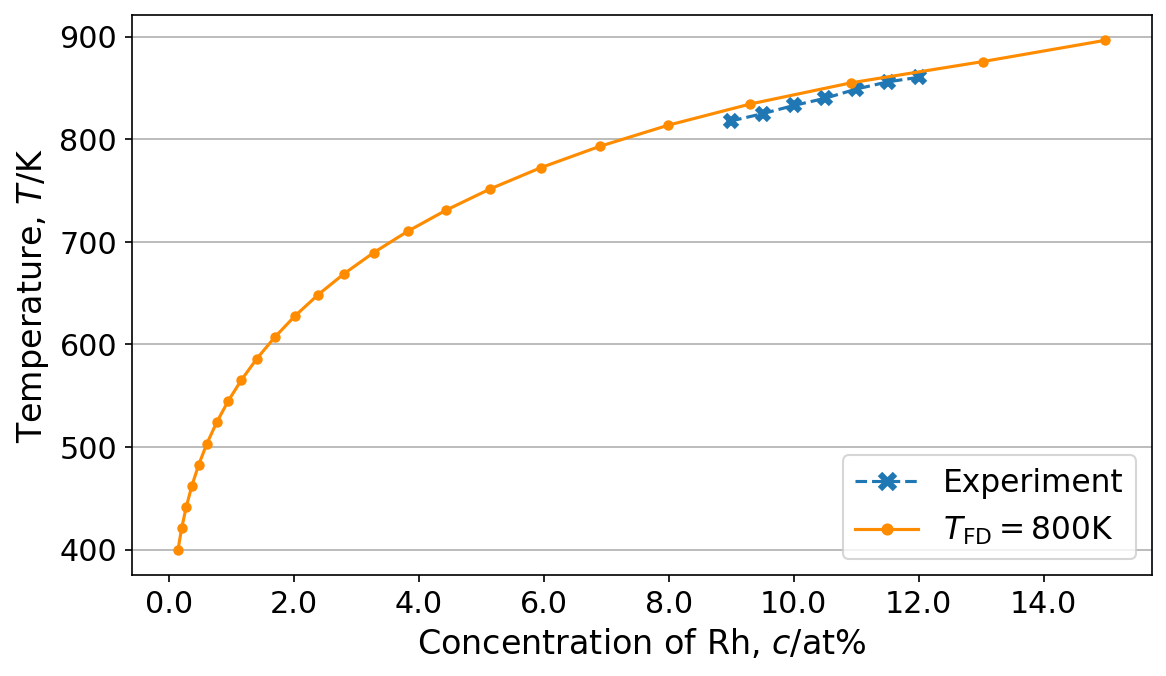

In [24]:
tmp = tetra.results.loc['800k'].groupby('temperature').last()
process(tetra.meta, dict(temp=tmp.index.values, c=tmp['concentration'].values, label='$T_\\mathrm{FD}=800$K'), experiment=tetra.experiment)